# Загрузка файлов и настройка
результат: train, target, test - загружены

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint
import numpy as np


train = pd.read_parquet("train.parquet")
target = pd.read_csv("train_target.csv")
test = pd.read_parquet("test.parquet")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Предобаботка
результат: merged_df_train - добавлен таргет, clean_df_train - очищены NaN и target < 0

In [4]:
merged_df_train = train.join(target)
merged_df_train['mb_target'] = pd.to_timedelta(train['date_depart'] - train['prev_date_arrival']).dt.total_seconds() / 3600
merged_df_train.head(2)

,wagnum,prev_fr_id,prev_is_load,prev_date_depart,prev_date_arrival,prev_snd_org_id,prev_rsv_org_id,prev_distance,snd_st_id,rsv_st_id,fr_id,is_load,date_depart,rod,common_ch,vidsobst,snd_org_id,rsv_org_id,distance,prev_freight,prev_fr_group,freight,fr_group,target,mb_target
0,11,1399685,0.0,2022-03-30 22:55:00,2022-04-05 11:07:00,4266126,2279057,4493.0,3609555,4985724,292757,1,2022-04-07 08:45:00,8,9.0,Собственные,2279057,9321847,269.0,ГАЗЫ УГЛЕВОД ПР,Нефтяные грузы,БАНКЕТКИ,Остальные грузы,45.0,45.633333
1,11,292757,1.0,2022-04-07 08:45:00,2022-04-07 18:22:00,2279057,9321847,269.0,4985724,2492408,8674472,1,2022-04-11 07:30:00,8,9.0,Собственные,9321847,4272291,3584.0,БАНКЕТКИ,Остальные грузы,ГАРНИТУРЫ КУХОН,Остальные грузы,85.0,85.133333


In [5]:
clean_df_train = merged_df_train.drop(merged_df_train[merged_df_train.mb_target < 0].index).dropna()
merged_df_train.isna().describe()

,wagnum,prev_fr_id,prev_is_load,prev_date_depart,prev_date_arrival,prev_snd_org_id,prev_rsv_org_id,prev_distance,snd_st_id,rsv_st_id,fr_id,is_load,date_depart,rod,common_ch,vidsobst,snd_org_id,rsv_org_id,distance,prev_freight,prev_fr_group,freight,fr_group,target,mb_target
count,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699
unique,1,1,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1560699,1560699,1560699,1560695,1560451,1560699,1560699,1559345,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1560699,1558995,1560698,1560698,1560695,1560695,1560451,1560451


# Первичная визуализация

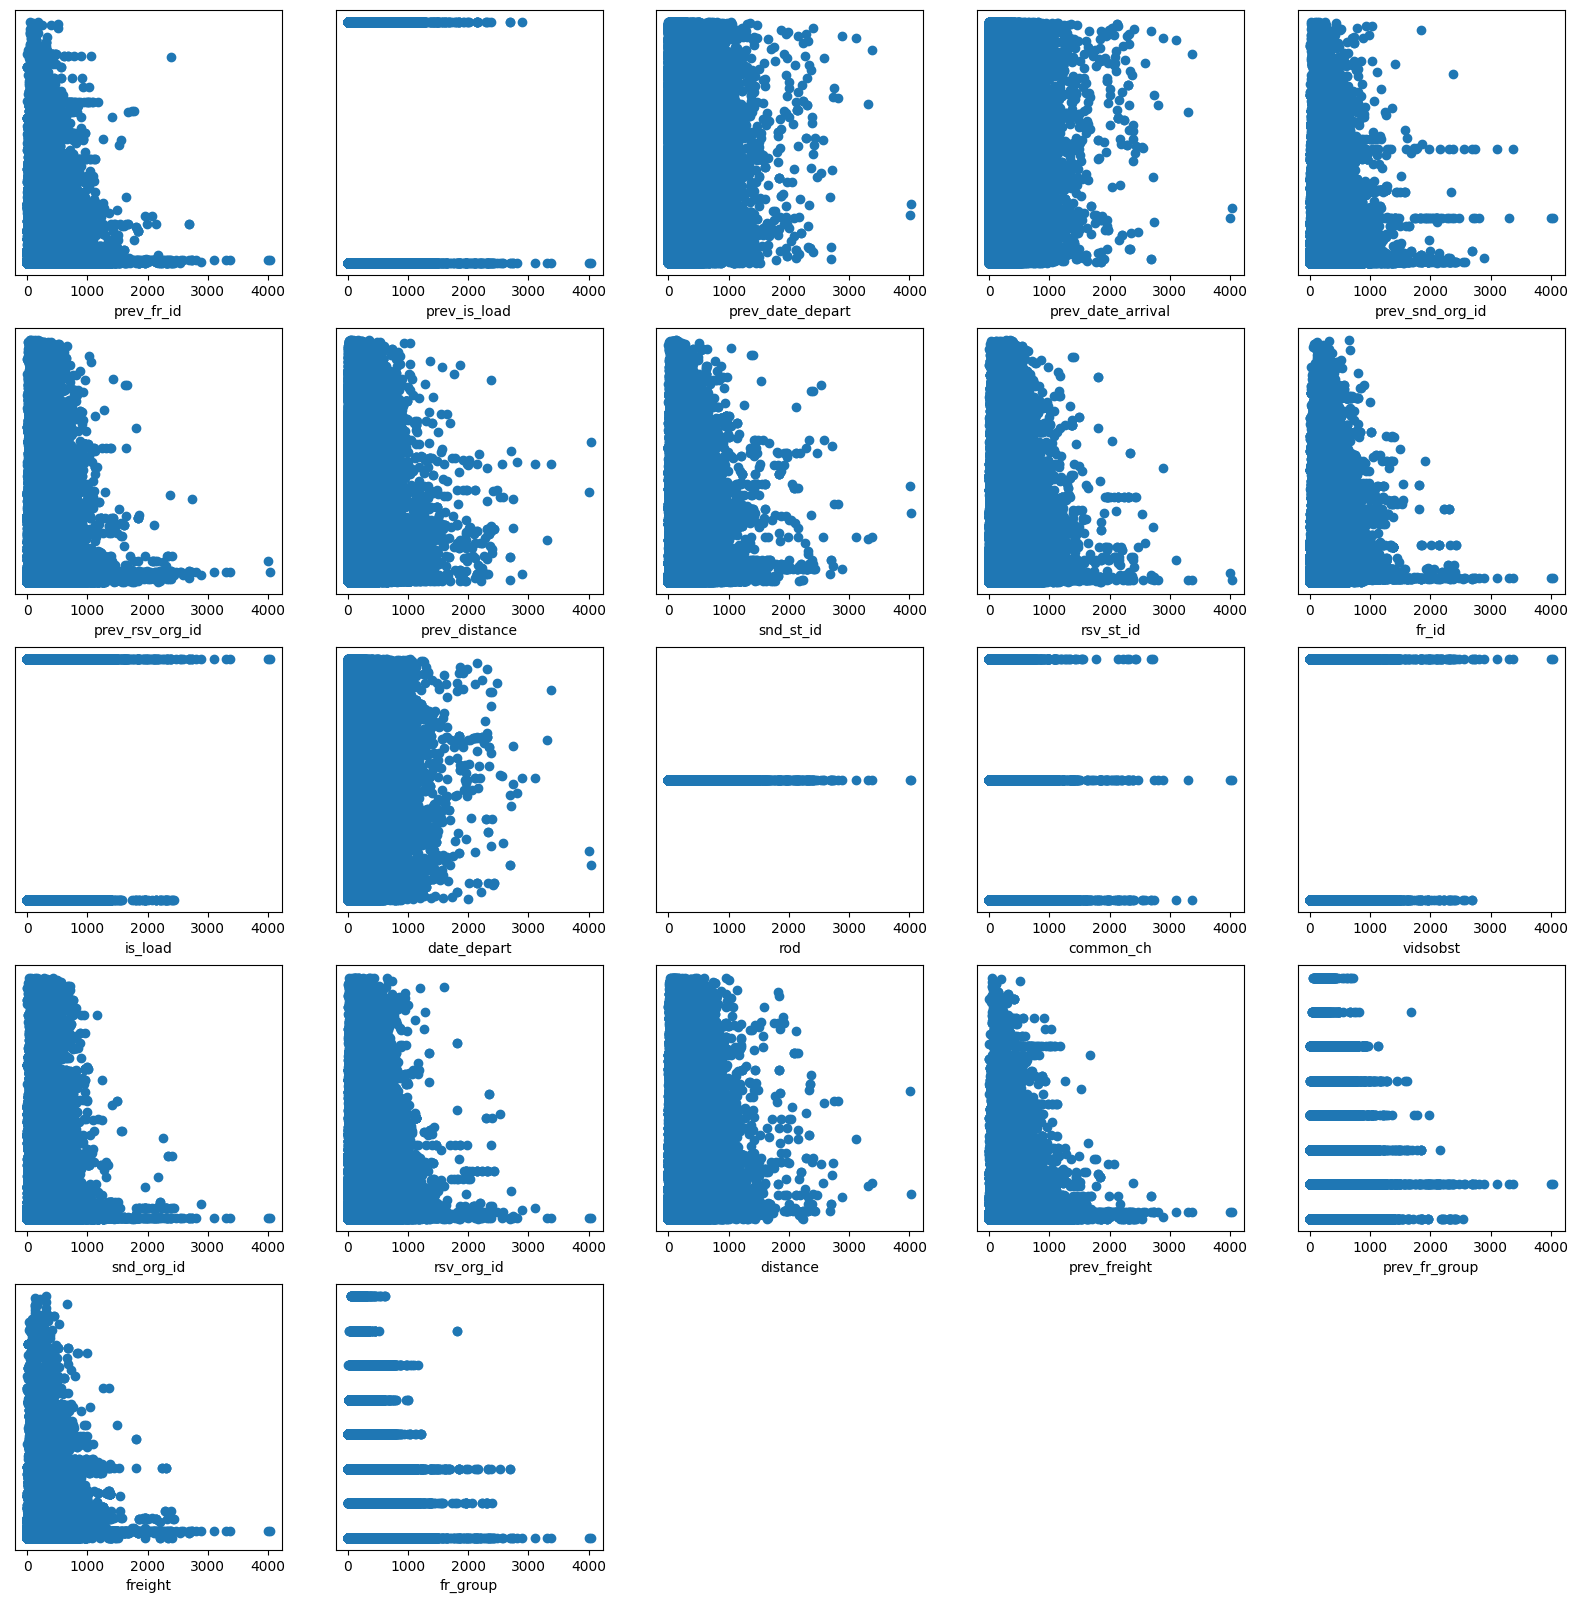

In [8]:
# cols = clean_df_train.columns.drop(['target','wagnum','mb_target'])
# i = 0
# plt.figure(figsize=(20,20))
# for col in cols:
#     i+=1
#     plt.subplot(5,5,i)
#     plt.scatter(clean_df_train['mb_target'], list(map(str, clean_df_train[col])))
#     plt.yticks([])
#     plt.xlabel(col)
# clean_df_train.plot(kind='scatter',x=['mb_target']*cols.size,y=cols,subplots=True,)

# Предобработка 2
результат: merged_df_train, clean_df_train - привидены к численным типам

In [6]:
merged_df_train['mb_target'] = pd.to_timedelta(train['date_depart'] - train['prev_date_arrival']).dt.total_seconds() / 3600


date_cols = ['date_depart', 'prev_date_depart', 'prev_date_arrival']

for col in date_cols:
    merged_df_train[col] = (pd.to_timedelta(train[col] - train.at[0, 'date_depart']).dt.total_seconds() / 3600)

# create an instance of the LabelEncoder class
label_encoder = LabelEncoder()
cat_columns = merged_df_train.select_dtypes('object').columns

for col in cat_columns:
    merged_df_train[col] = label_encoder.fit_transform(merged_df_train[col])

clean_df_train = merged_df_train.drop(merged_df_train[merged_df_train.target < 0].index).dropna()


# Корреляции
результат: X_train, y_train - выбранные по анализу матрицы корреляций параметры и таргет

### первичные корреляции

In [10]:
cor = clean_df_train.drop(columns=['date_depart', 'wagnum']).corr()


<AxesSubplot:>

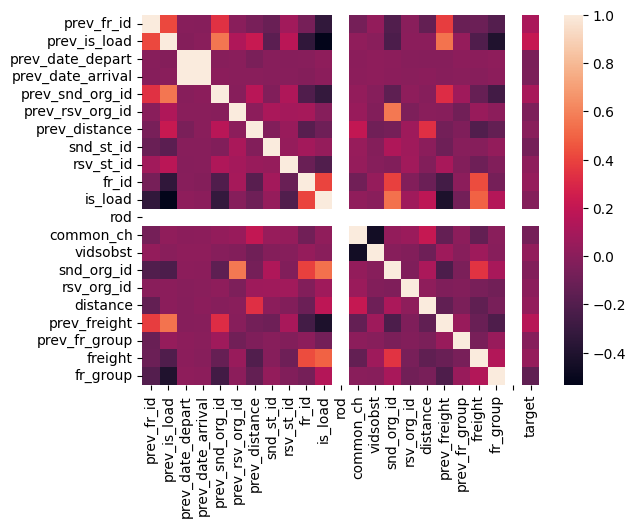

In [11]:
sns.heatmap(cor.drop(columns=['target','mb_target']).join(pd.Series([1]*(cor.size),name='')).join(cor['target']).drop(['target','mb_target']))

### корреляции с таргетом

In [12]:
cor.loc['mb_target']

prev_fr_id           0.109705
prev_is_load         0.211184
prev_date_depart    -0.055941
prev_date_arrival   -0.048075
prev_snd_org_id      0.107056
prev_rsv_org_id     -0.043264
prev_distance       -0.002890
snd_st_id           -0.071851
rsv_st_id            0.016837
fr_id                0.040888
is_load             -0.018737
rod                       NaN
common_ch           -0.076962
vidsobst             0.026402
snd_org_id          -0.026685
rsv_org_id           0.003271
distance             0.031993
prev_freight         0.160781
prev_fr_group       -0.015402
freight              0.041965
fr_group            -0.153273
target               0.999995
mb_target            1.000000
Name: mb_target, dtype: float64

### анализ и выборка корреляций между параметрами

In [13]:
def f(x): 
    if x > 0.5 and x!=1: return x 
    else: return ''
cor.drop(['target','mb_target']).apply(lambda x: x.apply(f))

,prev_fr_id,prev_is_load,prev_date_depart,prev_date_arrival,prev_snd_org_id,prev_rsv_org_id,prev_distance,snd_st_id,rsv_st_id,fr_id,is_load,rod,common_ch,vidsobst,snd_org_id,rsv_org_id,distance,prev_freight,prev_fr_group,freight,fr_group,target,mb_target
prev_fr_id,,,,,,,,,,,,,,,,,,,,,,,
prev_is_load,,,,,0.562298,,,,,,,,,,,,,0.547847,,,,,
prev_date_depart,,,,0.996155,,,,,,,,,,,,,,,,,,,
prev_date_arrival,,,0.996155,,,,,,,,,,,,,,,,,,,,
prev_snd_org_id,,0.562298,,,,,,,,,,,,,,,,,,,,,
prev_rsv_org_id,,,,,,,,,,,,,,,0.567055,,,,,,,,
prev_distance,,,,,,,,,,,,,,,,,,,,,,,
snd_st_id,,,,,,,,,,,,,,,,,,,,,,,
rsv_st_id,,,,,,,,,,,,,,,,,,,,,,,
fr_id,,,,,,,,,,,,,,,,,,,,,,,


<AxesSubplot:xlabel='prev_distance', ylabel='distance'>

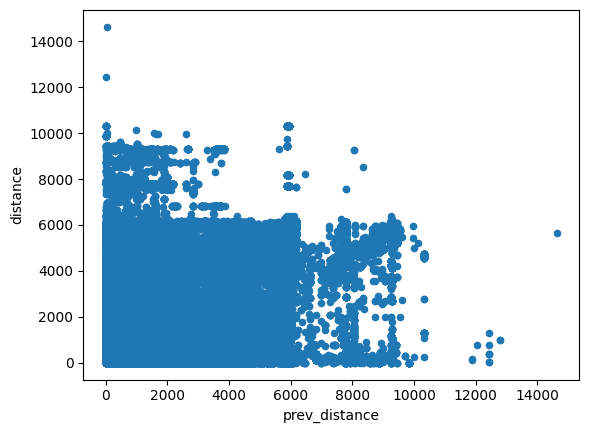

In [14]:
clean_df_train.plot(kind='scatter',y='distance',x='prev_distance')

In [9]:
correlated_cols=['date_depart','prev_date_depart','prev_snd_org_id','prev_rsv_org_id','snd_org_id','rsv_org_id','freight','prev_freight','rod','prev_distance']

cor2 = clean_df_train.drop(columns=
    ['wagnum']+correlated_cols).corr()

In [16]:
def f(x): 
    if x > 0.2: return x 
    else: return ''
cor2.drop(['target','mb_target']).apply(lambda x: x.apply(f))

,prev_fr_id,prev_is_load,prev_date_arrival,snd_st_id,rsv_st_id,fr_id,is_load,common_ch,vidsobst,distance,prev_fr_group,fr_group,target,mb_target
prev_fr_id,1.0,0.418497,,,,,,,,,,,,
prev_is_load,0.418497,1.0,,,,,,,,,,,0.21119,0.211184
prev_date_arrival,,,1.0,,,,,,,,,,,
snd_st_id,,,,1.0,,,,,,,,,,
rsv_st_id,,,,,1.0,,,,,,,,,
fr_id,,,,,,1.0,0.404541,,,,,,,
is_load,,,,,,0.404541,1.0,,,,,,,
common_ch,,,,,,,,1.0,,0.210907,,,,
vidsobst,,,,,,,,,1.0,,,,,
distance,,,,,,,,0.210907,,1.0,,,,


In [17]:
clean_df_train[['fr_id','is_load']][clean_df_train['freight']==292757]

,fr_id,is_load


### Визуализация корреляции выбранных парамтеров

<AxesSubplot:>

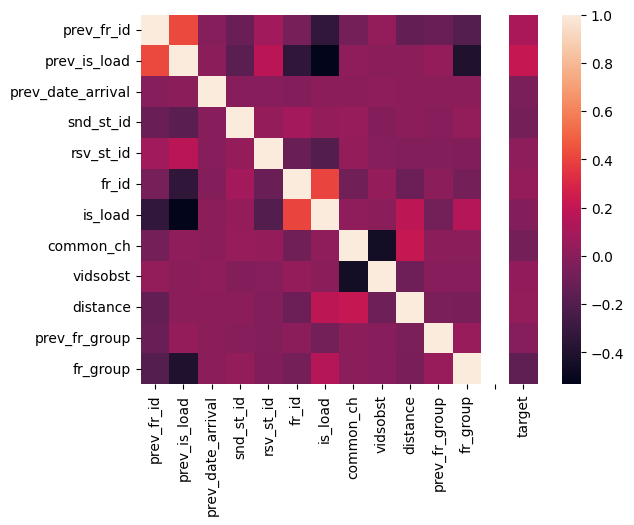

In [18]:
#cor2
sns.heatmap(cor2.drop(columns=['target','mb_target']).join(pd.Series([1]*(cor2.size),name='')).join(cor2['target']).drop(['target','mb_target']))

# Отчистка выбросов

In [7]:

def sigma_outlier(X, y=False, threshold=2):
    sd = np.std(X, axis=0)
    mean = np.mean(X, axis=0)
    upper = mean + threshold * sd
    lower = mean - threshold * sd
    idx = np.where((X < lower) | (X > upper))[0]
    mask = np.ones(X.shape[0], dtype=int)
    mask[idx] = -1
    if y:
        return X[mask == 1], y[mask == 1]
    return X[mask == 1]

clean_df_train = sigma_outlier(clean_df_train)

# Модель

In [10]:
X_train = clean_df_train.drop(columns=correlated_cols+['wagnum','target','mb_target','prev_date_arrival','date_depart'])
y_train = clean_df_train['mb_target']

In [14]:
def error(y1, y2):
    dy = pd.DataFrame({0:y1, 1:y2})
    return float(dy[abs(dy[0]-dy[1])<12][0].count()/dy[0].count())

In [253]:
pca = StandardScaler()  

d = 8 # stride for rows X_train: more d - less quality of model

pca.fit(X_train.iloc[3::d])

joblib.dump(pca, 'pca.joblib')

X_train_p = pca.transform(X_train.iloc[3::d])

# Create a RandomForestRegressor object
rf = RandomForestRegressor()

# Define the hyperparameters to tune
params = {
    'n_estimators': randint(400, 450),
    'max_depth': randint(13, 17),
    'min_samples_split': randint(3, 6),
    'min_samples_leaf': randint(1, 3)
}
# params = {
#     'max_depth': range(1, 10),
#     'n_estimators': range(10, 101, 10),
#     'min_samples_leaf': range(1, 8),
#     'min_samples_split': range(2, 10, 2)
# }

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
                estimator=rf, 
                scoring=make_scorer(error, greater_is_better=True), 
                param_distributions=params)

# machine learning b*tch
random_search.fit(X_train_p, y_train.iloc[3::d])


KeyboardInterrupt: 

In [250]:

print(error(y_train.iloc[2::d],random_search.best_estimator_.predict(pca.transform(X_train.iloc[2::d]))))

0.4212641886255046


In [11]:

# Print the best hyperparameters
print(random_search.best_params_, random_search.best_score_)

final_model = random_search.best_estimator_

joblib.dump(final_model, 'final_model.joblib')

NameError: name 'random_search' is not defined

In [31]:
# rf = joblib.load('final_model.joblib')
# pca = joblib.load('pca.joblib')
d = 8
print(error(y_train.iloc[3::d],rf.predict(pca.transform(X_train.iloc[3::d]))))

0.4093039388879478


### Предикт

In [71]:
if 'date_depart' in correlated_cols:
    correlated_cols.remove('date_depart')
clear_test = test.drop(columns=correlated_cols+['wagnum'])

clear_test['prev_date_arrival'] = (pd.to_timedelta(clear_test['prev_date_arrival'] - train.at[0, 'date_depart']).dt.total_seconds() / 3600)

# create an instance of the LabelEncoder class
label_encoder = LabelEncoder()
cat_columns = clear_test.select_dtypes('object').columns

for col in cat_columns:
    clear_test[col] = label_encoder.fit_transform(clear_test[col])

X_test = clear_test.drop(columns=['prev_date_arrival']).fillna(method='ffill')

# Use the predict method of the loaded model to make predictions on new data
y_pred = rf.predict(pca.transform(X_test))
pd.Series(y_pred,name='target').to_csv("submit.csv",index=False)
print(y_pred)


[160.89621167  96.76423444 165.93874751 ...  49.75365676 120.81126057
 151.99843956]
